# Mean solvation across membrane
In this notebook, 
I calculate and Plot the mean solvation 
(mean number of solvent particles from `gmx mindist` called `numcont`)
as a function of the distance from the membrane center (from `pullx`).

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, fnmatch
import pickle


In [2]:
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result


def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
    supplied root directory.'''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield os.path.join(path, filename)


In [3]:
class Simulation:
    """
    class that is very specific to the use with my permeability project.
    It uses pre-analyzed results from Gromacs
    to calculate the mean hydration along the membrane normal.
    """
    def __init__(self, pullx_fname='pullx.xvg', numcont_fname="numcont_particle-solvent.xvg"):
        self.dirname       = os.path.dirname(pullx_fname)
        self.pullx_fname   = pullx_fname
        self.numcont_fname = numcont_fname
        
        
    def load_df(self, fname, columns, app_func=None):
        """
        methods loads a xvg file (expecting only two columns) 
        and turnes it into a dataframe with the described column names.
        columns shall be a list of column names.
        app_func is a name of a function to be applied on the resulting DataFrame
        """
        arr = np.loadtxt(fname, dtype=float, comments=["#", "@"])
        df  = pd.DataFrame(arr, columns=columns).set_index(columns[0])
        if app_func:
            df = df.apply(app_func)
            
        return df

    
    def merge2dfs(self, df1, df2, on_index='t'):
        "simply merge two dataframes o the specified index name"
        return df1.merge(df2, on=on_index)
    
    
    def load_xnt_df(self):
        """
        loads in necessarry data to return 
        a DataFrame containing the x - numcont values 
        with t as index
        """
        df = self.merge2dfs(self.load_df(self.pullx_fname, columns=['t', 'x'], app_func=abs),
                                   self.load_df(self.numcont_fname, columns=['t', 'numcont']))
        #df.numcont = df.numcont.apply(int)
        return df
      
        
    @property
    def mean_solv(self):
        try:
            return self.__mean_solv_df
        except:
            return self.calc_mean_solv()
            

    @property
    def degree_of_solv(self):
        """
        using a definition that 0=dry ; 1=in contact with solvent
        the average value tells on the probability of 
        being dry -vs- in contact with at least one solvent molecule. 
        """
        try:
            return self.__degree_of_solv_df
        except:
            return self.calc_mean_solv(degree_of_solv=True)
            
    
    def calc_mean_solv(self, bins=40, degree_of_solv=False):
        """
        calculate the profile of mean solvation (incl. std).
        input DataFrame has to have a column 'x'
        and
        calculate the degree of solbvation - stores as a hidden variable
        """
        # load the files to make the x-numcont(t) DataFrame
        xnbinst = self.load_xnt_df()
        # perform binning (equal sizes)
        xnbinst['bins'] = pd.cut(xnbinst.x, bins=bins)
        # empty list to contain the final array
        mean_solvation_list = []
        degree_of_solvation_list = []
        for group in xnbinst.groupby(by='bins'):
            grind = group[0]
            df = group[1]
            # store the center of the bin and the mean+std of solvation value
            mean_solvation_list.append([grind.mid, df.numcont.agg(np.mean), df.numcont.agg(np.std)])
            # change the DF so that numcont value is truncated to 1 for higher values
            df['degsolv'] = df['numcont'].where(df['numcont']<1.0, other=1.0)
            degree_of_solvation_list.append([grind.mid, df.degsolv.agg(np.mean), df.degsolv.agg(np.std)])

        self.__mean_solv_df = pd.DataFrame(mean_solvation_list, 
                                           columns=["x [nm]", "num_solvent mean", "num_solvent std"])
        self.__degree_of_solv_df = pd.DataFrame(degree_of_solvation_list, 
                                           columns=["x [nm]", "degree of solvation mean", "degree of solvation std"])
        
        if degree_of_solv:
            return self.__degree_of_solv_df
        else:
            return self.__mean_solv_df


    def plot_mean_solv_profile(self, alpha=0.5, plt_label=None, plt_stdev=False, plt_solvdeg=False):
        """
        output: seaborn plot of the mean solvation profile including a
        Standard deviation as a fill-between area
        """
        if plt_solvdeg:
            colname = 'degree of solvation'
            simdf = self.degree_of_solv
        else:
            colname = 'num_solvent'
            simdf = self.mean_solv
            
        simdf['y1'] = simdf[colname+' mean'] + simdf[colname+' std']
        simdf['y2'] = simdf[colname+' mean'] - simdf[colname+' std']
        simdf['y2'] = simdf['y2'].where(simdf['y2']>0.0, other=0.0)
        
        # store the DF for quick check and access
        self.simdf = simdf.copy()
        
        #plotting!
        fig = sns.lineplot(data=simdf, x='x [nm]', y=colname+' mean', label=plt_label )
        if plt_stdev:
            fig.fill_between(data=simdf, x='x [nm]', y1='y1', y2='y2', alpha=alpha)
        
        return fig

# Solvent accessibility & average solvaiton profiles 
by plotting whether there is at least one molecule within cutoff 
& the average numcont value per bin/gridpoint

This property does not need to be reweighted as the averages per each bin 
are independent. 
Only sufficient amount of sampling is necessary. 

Here, selecting all simulation folders containing the pullx file (which is totally necessarry).

In [4]:
# find all pullx files in the curdir and below
pullx_files = find("pullx.xvg", os.curdir)

# create Simulation class instance based on the generated data
sims    = []
for f in pullx_files:
    dirname = os.path.dirname(f)
    numcont_fname = os.path.join(dirname, "numcont_particle-solvent.xvg")
    sim = Simulation(pullx_fname=f, numcont_fname=numcont_fname)
    sims.append(sim)
    print(dirname)


./cholesterol26p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_179-0_d_0/sim1_awh_LOrdered
./cholesterol26p_PC_variousTails_sims/prep_min_eq/long_eq
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLR/sat-unsat_82-36_d_15/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLR/sat-unsat_58-60_d_25/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLR/sat-unsat_22-96_d_40/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLR/sat-unsat_46-72_d_30/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLR/sat-unsat_106-12_d_5/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLR/sat-unsat_118-0_d_0/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-P

## POPC + sterols membranes

In [53]:
#selected_particles = ["SC5", "SP3", "SP6", "SN2", "SN3"]
sns.set_palette("Blues_r", n_colors=4)  #len(sims))

In [54]:
# selection for "all" and "any" functions
# these shall select simulations with d=0 (saturated) and the listed sterol concentrations
sel_kwords_dirname = ["EOLS", "d_50"]
sel_kwords_dirname_any = ["0p", "15p", "30p", "45p"]

In [55]:
# set the plotting label from the dirname
sims_popc = []
for s in sims:
    # this shall select the sterol concentration as written in the directory name
    # and apply it as an attribute "label" to the simulation instance
    s.label = s.dirname[13:15]
    if all(x in s.dirname for x in sel_kwords_dirname) and any(x in s.dirname for x in sel_kwords_dirname_any) and not any(x in s.dirname for x in ["AWHk", "(1)"]):
        print(s.dirname)
        sims_popc.append(s)

./cholesterol00p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_0-169_d_50/sim1_awh_fluid
./cholesterol15p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_0-179_d_50/sim1_awh_gel
./cholesterol30p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_0-179_d_50/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_0-118_d_50/sim1_awh_LOrdered


In [56]:
# sort the list of simulations after their particle name (follows solubility, yay!)
sims.sort(key=lambda sim: sim.label)

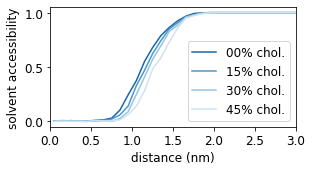

In [58]:
# make a plot of the solvent accessibility profile for each simulation 
for sim in sims:
    s = sim
    if all(x in s.dirname for x in sel_kwords_dirname) and any(x in s.dirname for x in sel_kwords_dirname_any) and not any(x in s.dirname for x in ["AWHk", "(1)"]):   #any(x in sim.dirname for x in selected_particles):
        try: 
            fig = sim.plot_mean_solv_profile(plt_label="{}% chol.".format(sim.label), plt_solvdeg=True)
        except:
            pass

#fig.figure.set_size_inches([4.4,2.2])
fig.set_xlabel("distance (nm)")
fig.set_ylabel("solvent accessibility")

fig.set_xlim([-0.1, 4.1])
fig.figure.savefig("solvent_accessibility_profiles_unsatur-d50_sterol-series.png", dpi=150, bbox_inches='tight')

fig.figure.set_size_inches([4.4,2.2])
fig.set_xlim([0.0,3.0])
fig.figure.savefig("solvent_accessibility_profiles_unsatur-d50_sterol-series_zoomin.png", dpi=150, bbox_inches='tight')


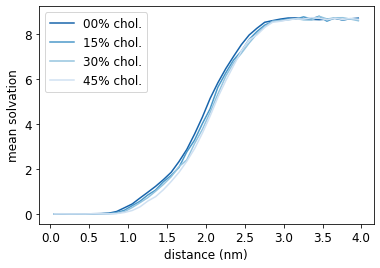

In [59]:
# make a plot of the mean solvation profile for each simulation 
for sim in sims:
    s = sim
    if all(x in s.dirname for x in sel_kwords_dirname) and any(x in s.dirname for x in sel_kwords_dirname_any) and not any(x in s.dirname for x in ["AWHk", "(1)"]):  #any(x in sim.dirname for x in selected_particles):
        try: 
            fig = sim.plot_mean_solv_profile(plt_label="{}% chol.".format(sim.label))
        except:
            pass

#fig.figure.set_size_inches([4d.4,2.2])

fig.set_xlabel("distance (nm)")
fig.set_ylabel("mean solvation")
        
fig.figure.savefig("mean_solvation_profiles_unsatur-d50_sterol-series.png", dpi=150, bbox_inches='tight')

#fig.set_xlim([0.5,2.2])
#fig.set_ylim([-0.1, 8.0])
#fig.figure.savefig("mean_solvation_profiles_zoomin.png", dpi=150, bbox_inches='tight')


## DPPC + sterols membranes

In [41]:
#selected_particles = ["SC5", "SP3", "SP6", "SN2", "SN3"]
sns.set_palette("Reds_r", n_colors=4)  #len(sims))

In [42]:
# selection for "all" and "any" functions
# these shall select simulations with d=0 (saturated) and the listed sterol concentrations
sel_kwords_dirname = ["EOLS", "d_0"]
sel_kwords_dirname_any = ["0p", "15p", "30p", "45p"]

In [43]:
# set the plotting label from the dirname
sims_dppc = []
for s in sims:
    # this shall select the sterol concentration as written in the directory name
    # and apply it as an attribute "label" to the simulation instance
    s.label = s.dirname[13:15]
    if all(x in s.dirname for x in sel_kwords_dirname) and any(x in s.dirname for x in sel_kwords_dirname_any) and not any(x in s.dirname for x in ["AWHk", "(1)"]):
        print(s.dirname)
        sims_dppc.append(s)

./cholesterol00p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_169-0_d_0/sim1_awh_gel
./cholesterol15p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_179-0_d_0/sim1_awh_gel
./cholesterol30p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_179-0_d_0/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_118-0_d_0/sim1_awh_LOrdered


In [44]:
# sort the list of simulations after their particle name (follows solubility, yay!)
sims.sort(key=lambda sim: sim.label)

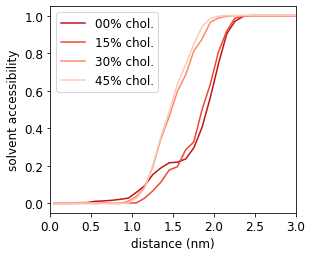

In [50]:
# make a plot of the solvent accessibility profile for each simulation 
for sim in sims:
    s = sim
    if all(x in s.dirname for x in sel_kwords_dirname) and any(x in s.dirname for x in sel_kwords_dirname_any) and not any(x in s.dirname for x in ["AWHk", "(1)"]):   #any(x in sim.dirname for x in selected_particles):
        try: 
            fig = sim.plot_mean_solv_profile(plt_label="{}% chol.".format(sim.label), plt_solvdeg=True)
        except:
            pass

#fig.figure.set_size_inches([4.4,2.2])
fig.set_xlabel("distance (nm)")
fig.set_ylabel("solvent accessibility")

fig.set_xlim([-0.1, 4.1])
fig.figure.savefig("solvent_accessibility_profiles_satur-d0_sterol-series.png", dpi=150, bbox_inches='tight')

fig.figure.set_size_inches([4.4,3.8])
fig.set_xlim([0.0,3.0])
fig.figure.savefig("solvent_accessibility_profiles_satur-d0_sterol-series_zoomin.png", dpi=150, bbox_inches='tight')


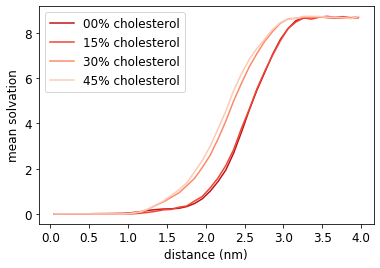

In [51]:
# make a plot of the mean solvation profile for each simulation 
for sim in sims:
    s = sim
    if all(x in s.dirname for x in sel_kwords_dirname) and any(x in s.dirname for x in sel_kwords_dirname_any) and not any(x in s.dirname for x in ["AWHk", "(1)"]):  #any(x in sim.dirname for x in selected_particles):
        try: 
            fig = sim.plot_mean_solv_profile(plt_label="{}% cholesterol".format(sim.label))
        except:
            pass

#fig.figure.set_size_inches([4.4,2.2])

fig.set_xlabel("distance (nm)")
fig.set_ylabel("mean solvation")
        
fig.figure.savefig("mean_solvation_profiles_satur-d0_sterol-series.png", dpi=150, bbox_inches='tight')

#fig.set_xlim([0.5,2.2])
#fig.set_ylim([-0.1, 8.0])
#fig.figure.savefig("mean_solvation_profiles_zoomin.png", dpi=150, bbox_inches='tight')


## Plot both DPPC and POPC + sterols together!

In [30]:
sims_dppc.reverse()
sims_selplot = sims_popc + sims_dppc

In [31]:
for s in sims_selplot:
    print(s.dirname)

./cholesterol00p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_0-169_d_50/sim1_awh_fluid
./cholesterol15p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_0-179_d_50/sim1_awh_gel
./cholesterol30p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_0-179_d_50/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_0-118_d_50/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_118-0_d_0/sim1_awh_LOrdered
./cholesterol30p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_179-0_d_0/sim1_awh_LOrdered
./cholesterol15p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_179-0_d_0/sim1_awh_gel
./cholesterol00p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_169-0_d_0/sim1_awh_gel


In [32]:
# let's use some cool palette!
sns.set_palette("PRGn", n_colors=len(sims_selplot))

# use a larger font
mpl.rcParams.update({'font.size': 12})

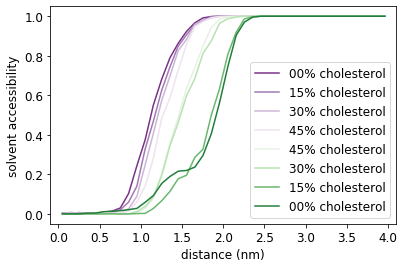

In [33]:
# make a plot of the solvent accessibility profile for each simulation 
for sim in sims_selplot:
    s = sim
    if True:
        try: 
            fig = sim.plot_mean_solv_profile(plt_label="{}% cholesterol".format(sim.label), plt_solvdeg=True)
        except:
            pass

fig = plt.gca()
fig.figure.set_size_inches([6.2,4.0])

#fig.figure.set_size_inches([4.4,2.2])
fig.set_xlabel("distance (nm)")
fig.set_ylabel("solvent accessibility")

fig.set_xlim([-0.1, 4.1])
fig.figure.savefig("solvent_accessibility_profiles_satur-d0and50_sterol-series.png", dpi=150, bbox_inches='tight')

#fig.figure.set_size_inches([4.4,3.8])
#fig.set_xlim([0.0,3.0])
#fig.figure.savefig("solvent_accessibility_profiles_satur-d0and50_sterol-series_zoomin.png", dpi=150, bbox_inches='tight')


## Object I/O — Save it/load it — pickle

In [60]:
# save the list of simulations
with open("mean_solvation_obj_list.pickle", 'bw') as picfile: 
    pickle.dump(sims, picfile)
    print("Saved the sims list to: ", picfile.name)
    

Saved the sims list to:  mean_solvation_obj_list.pickle


In [5]:
# load the list of simulations
with open("mean_solvation_obj_list.pickle", 'br') as picfile: 
    sims = pickle.load(picfile)
    print("Loaded the list of Simulation class instances.")
    

Loaded the list of Simulation class instances.
